In [1]:
import numpy as np
import xcompy as xc
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import itertools

In [2]:
# plot style

marker = itertools.cycle(('o', 's', '*', '+', 'x')) 

plt.rcParams.update({
    # figure
    "figure.dpi": 300,   # higher quality image
    # text
    "font.size":10,
    "font.family": "serif",                  # uncomment for tex style
    "font.serif": ['Computer Modern Roman'], # uncomment for tex style
    "text.usetex": True,                     # uncomment for tex style
    # axes
    "axes.titlesize": 10,
    "axes.labelsize": 8,
    "axes.linewidth": 1,
    # ticks
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.labelsize":8,
    "ytick.labelsize":8,
    # grid
    "axes.grid" : True,
    "axes.grid.which" : "major",
     "grid.color": "lightgray",
     "grid.linestyle": ":",
     # legend
     "legend.fontsize":8,
    "legend.facecolor":'white',
    "legend.framealpha":1.0 ,  
     })


# Defining materials

In [3]:
from materials import Material, all_mats, mdict

target_mats = ['water',
               'air',
               'calcium',
               'iodine_in_water_20', 
               #'calcium_in_water_600'
              ]
mats = []
for m in all_mats:
    if m.name in target_mats:
        mats.append(m)
        print(m.name)
# mats = []
# for m in all_mats:
#     if m.name != 'iodine':
#         mats.append(m)
#         print(m.name)
#     if m.name == 'calcium_in_water_600':
#         print(m.matcomp)

air
calcium
water
iodine_in_water_20


[0.00025058 0.00021758]
[1.58008978 0.85388014]
[0.22692906 0.19869476]
[0.47338103 0.32100129]
[[1 3 0]
 [3 2 0]]


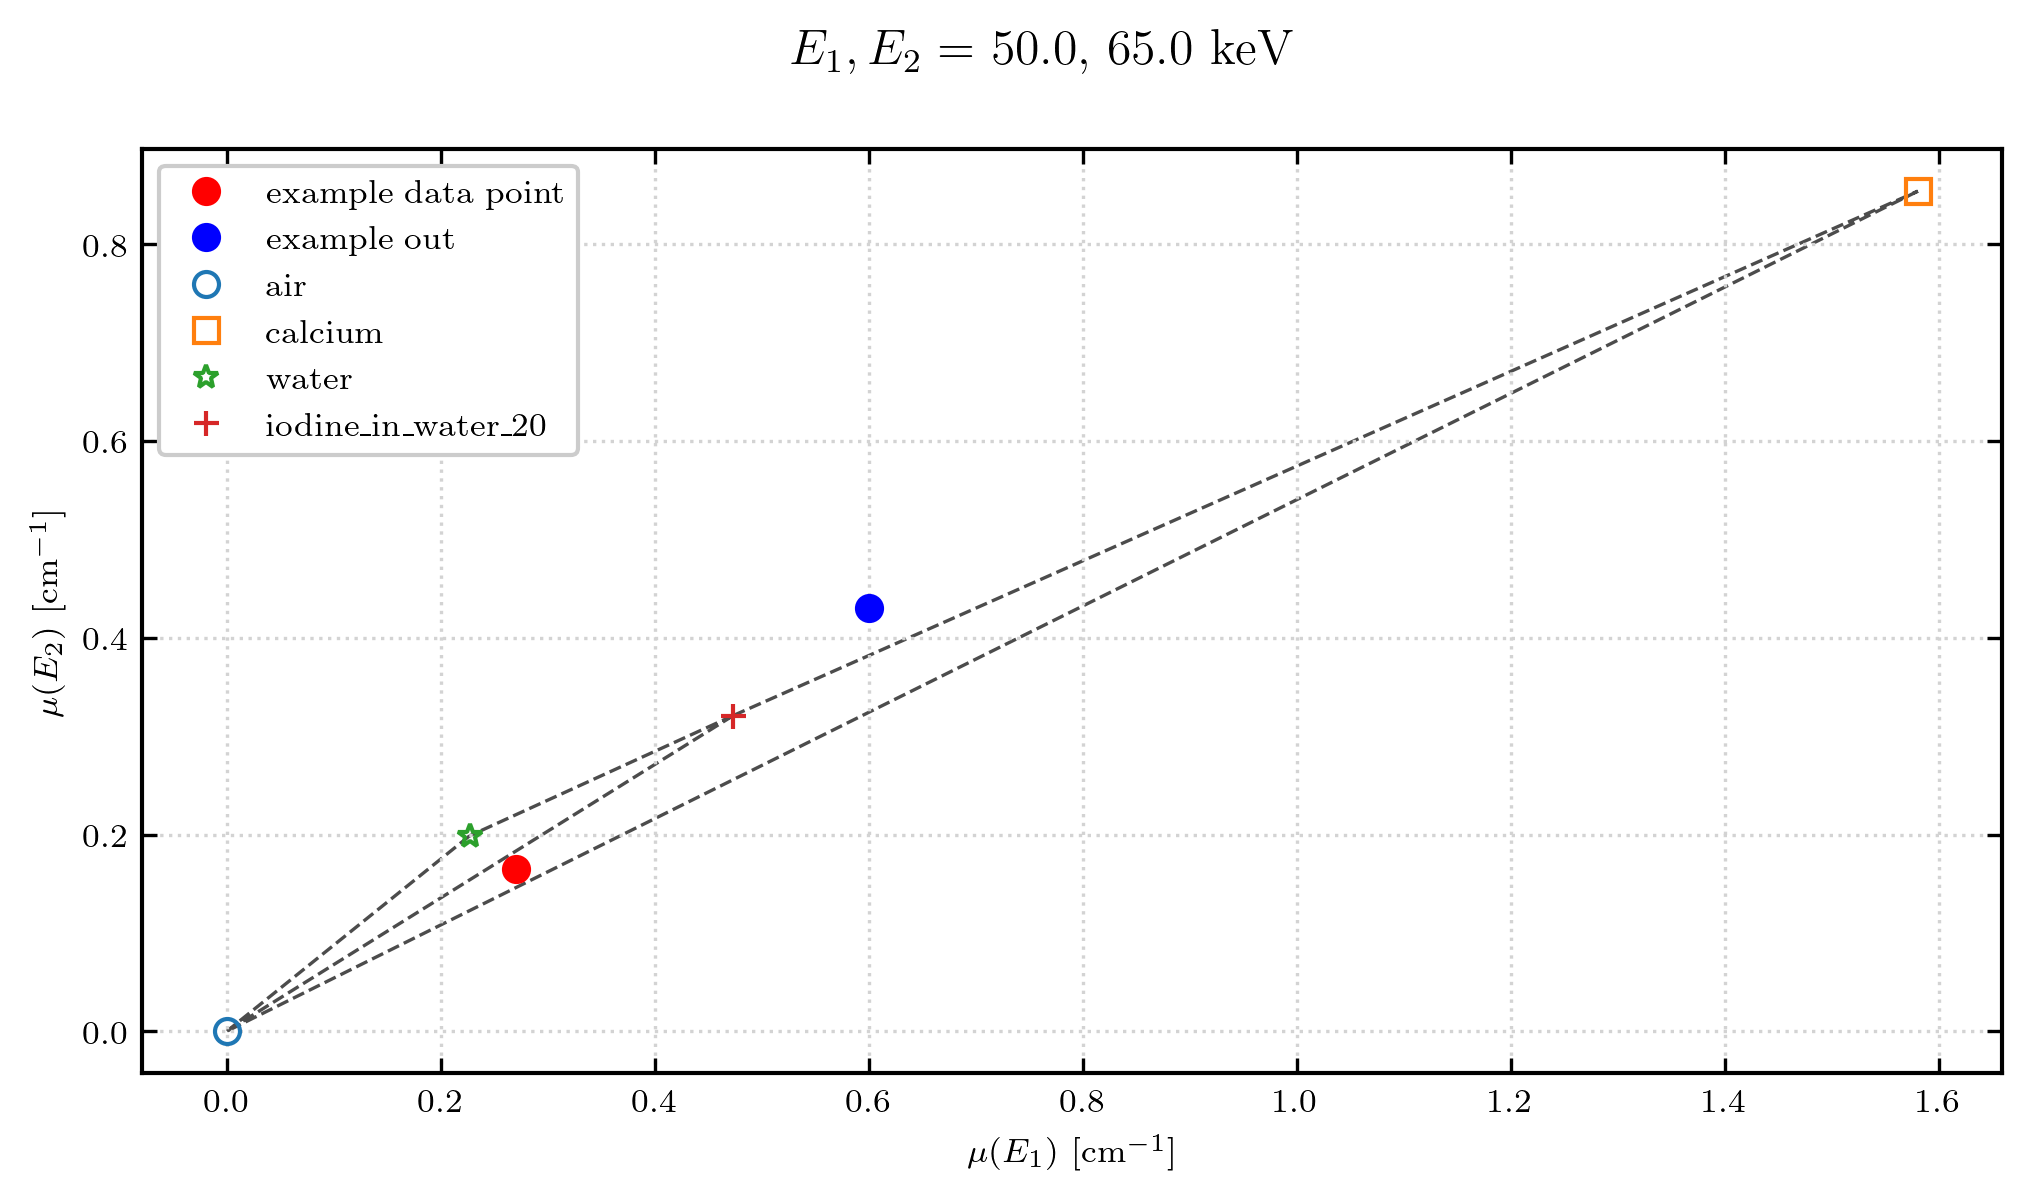

In [4]:
# choose dual energies
E1 = 50.0
E2 = 100.0
E1 = 50.0
E2 = 65.0
E = np.array([E1, E2])

# define example measurement
mu_meas = np.array([0.27, 0.165])

# example out
mu_meas_out = np.array([0.6,0.43])

# initialize attenuation coeff vectors 
# create full tesselation of triplets
points = []
for mat in mats:
    mat.init_atten_coeffs(E)
    points.append(mat.mu)
    print(mat.mu)
points = np.array(points)

# create tesselation
tri = Delaunay(points)
print(tri.simplices)

# check tesselaation

fig, ax = plt.subplots(1,1, figsize=[8,4])
fig.suptitle(f'$E_1, E_2 =$ {E1}, {E2} keV')

ax.plot(mu_meas[0], mu_meas[1], 'ro', label='example data point')
ax.plot(mu_meas_out[0], mu_meas_out[1], 'bo', label='example out')
#plt.plot(M_E1.ravel(), M_E2.ravel(), 'k.', markersize=.1, label='image data')

ax.triplot(points[:,0], points[:,1], tri.simplices, 'k--', lw=.8, alpha=0.7)
for mat in mats:
    ax.plot(mat.mu[0], mat.mu[1], marker=next(marker), ls='', markerfacecolor='None', label=mat.name)

ax.set_xlabel('$\mu(E_1)$ [cm$^{-1}$]')
ax.set_ylabel('$\mu(E_2)$ [cm$^{-1}$]')
ax.legend()
plt.show()

# Triple Material Decomposition (TMD)

In [5]:
# choose one triplet from our tesselation
triplet = np.take(mats, tri.simplices[1])
for mat in triplet:
    print(mat.name)
mu_triplet = np.array([m.mu for m in triplet])

iodine_in_water_20
water
air


In [6]:
# triple mat decomp (tmd)
# compute volume fractions for known three materials

def tmd(mu, triple):
    '''
    mu - vec of measured mu at E1, E2
    triple - triangle of truth mu vector coordinates
    solve for a (alphas) in Ma = x
    '''
    x = np.ones(3, dtype=np.float64)
    x[:2] = mu
    M = np.ones([3,3], dtype=np.float64)
    M[:2] = triple.T
    
    a = np.linalg.inv(M) @ x
    return a

tmd(mu_meas, mu_triplet)
    

array([ 0.76384318, -0.40430856,  0.64046538])

In [7]:
def tri_area(p1, p2, p3):
    area = 0.5 * (p1[0] * (p2[1] - p3[1]) 
            + p2[0] * (p3[1] - p1[1]) 
            + p3[0] * (p1[1] - p2[1]))
    return np.abs(area)

def tmd_area(mu, triple):
    '''
    check that area interpretation from mendonca is equivalent
    '''
    A1 = tri_area(mu, triple[1], triple[2])
    A2 = tri_area(mu, triple[0], triple[2])
    A3 = tri_area(mu, triple[0], triple[1])
    A = np.array([A1, A2, A3])

    alphas = np.array([Ai/np.sum(A) for Ai in A])
    return alphas

tmd_area(mu_meas, mu_triplet)

array([0.42233548, 0.22354569, 0.35411883])

# Multi-Triple Material Decomposition (MMD)

In [8]:

# choose optimal triangle
def is_inside(mu, triple, EPS=1e-8):
    '''
    a point P is inside a triangle ABC if 
    the sum of areas of PAB, PBC, PAC = area of ABC
    '''
    A = tri_area(triple[0], triple[1], triple[2])
    A1 = tri_area(mu, triple[0], triple[1])
    A2 = tri_area(mu, triple[1], triple[2])
    A3 = tri_area(mu, triple[0], triple[2])
    diff = np.abs(A-(A1+A2+A3))
    return diff < EPS
        
# in case the point is not inside the tesselation...
def d_hausdorff(mu, triple):
    '''
    mu - vec of measured mu at E1, E2
    triple - triangle of truth mu vector coordinates
    '''
    # make sure all numpy arrays
    mu = np.array(mu)
    triple = np.array(triple)

    # calc distance
    distances = np.zeros(3)
    for i in range(3):
        distances[i] = np.linalg.norm(triple[i] - mu)

    return np.min(distances)

In [9]:

mu_test = mu_meas_out


def get_alphas(mu_test, mats, tri):

    # init
    alphas = None
    min_hausdorff = 1e8  # something large
    
    for tri_inds in tri.simplices:
        triplet = np.take(mats, tri_inds)
        triplet_names = [m.name for m in triplet]
        mu_triplet = np.array([m.mu for m in triplet])   
    
        # first check triplets
        if is_inside(mu_test, mu_triplet):
            alphas = tmd(mu_test, mu_triplet)
            break
    
        # if not in triplets, prepare minimum hausdorff dist
        d = d_hausdorff(mu_test, mu_triplet) 
        if d < min_hausdorff:
            min_hausdorff = d
            
    
    if alphas is None: # not inside tesselation, go back through
        for tri_inds in tri.simplices:
            triplet = np.take(mats, tri_inds)
            triplet_names = [m.name for m in triplet]
            mu_triplet = np.array([m.mu for m in triplet])
    
            d = d_hausdorff(mu_test, mu_triplet) 
            if d==min_hausdorff:
                alphas = tmd(mu_test, mu_triplet)
                break
    return triplet_names, alphas

triplet_names, alphas = get_alphas(mu_test, mats, tri)
print(triplet_names, alphas)

['calcium', 'iodine_in_water_20', 'air'] [-0.10645348  1.62308049 -0.516627  ]


# Test an image

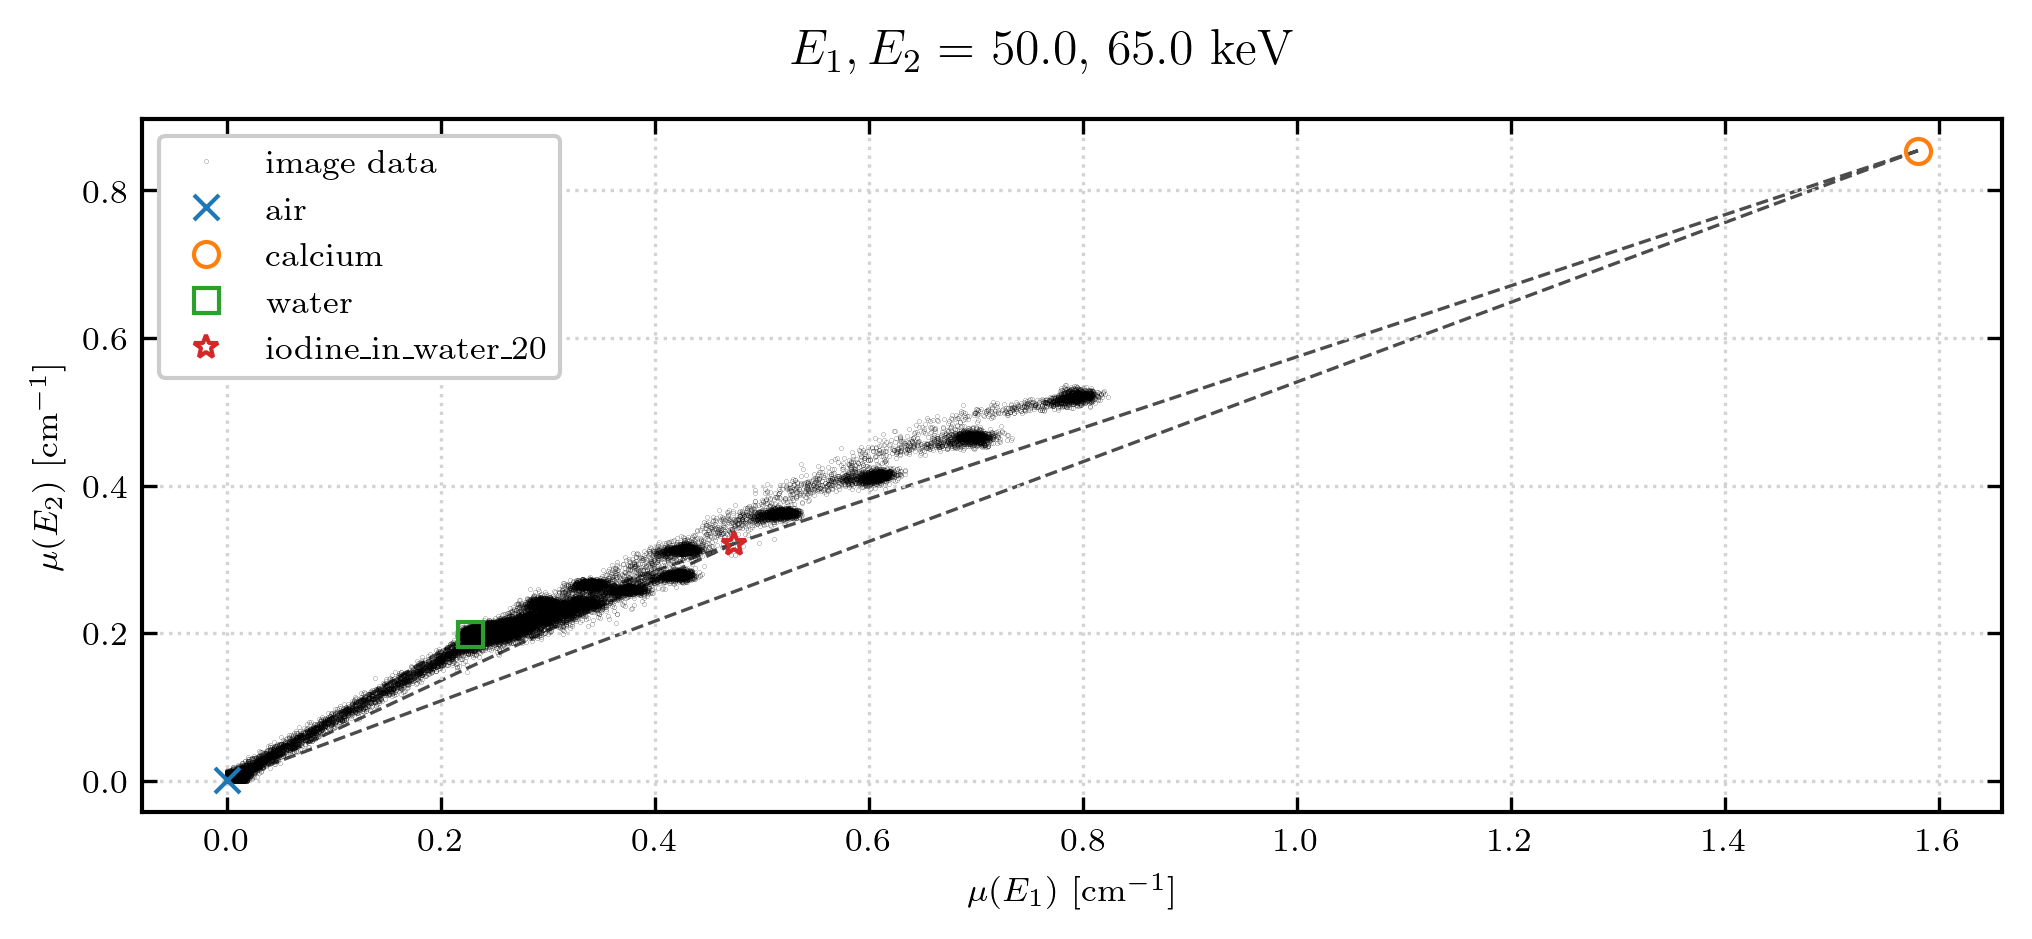

In [10]:
M_E1 = np.fromfile('data/test_imgs/M_E1.npy', dtype=np.float32).reshape([512,512])
M_E2 = np.fromfile('data/test_imgs/M_E2.npy', dtype=np.float32).reshape([512,512])

fig, ax = plt.subplots(1,1, figsize=[8,3])
fig.suptitle(f'$E_1, E_2 =$ {E1}, {E2} keV')

plt.plot(M_E1.ravel(), M_E2.ravel(), 'k.', markersize=.1, label='image data')

ax.triplot(points[:,0], points[:,1], tri.simplices, 'k--', lw=.8, alpha=0.7)
for mat in mats:
    ax.plot(mat.mu[0], mat.mu[1], marker=next(marker), ls='', markerfacecolor='None', label=mat.name)

ax.set_xlabel('$\mu(E_1)$ [cm$^{-1}$]')
ax.set_ylabel('$\mu(E_2)$ [cm$^{-1}$]')
ax.legend()
plt.show()

In [13]:
# initialize basis images
M_dict = {}
for m in mats:
    M_dict[m.name] = np.zeros([512,512], dtype=np.float32)

# compute images
for i in range(512):
    for j in range(512):
        mu_px = np.array([M_E1[i,j], M_E2[i,j]])
        triplet_names, alphas = get_alphas(mu_px, mats, tri)
        for k, name in enumerate(triplet_names):
            M_dict[name][i,j] = alphas[k]

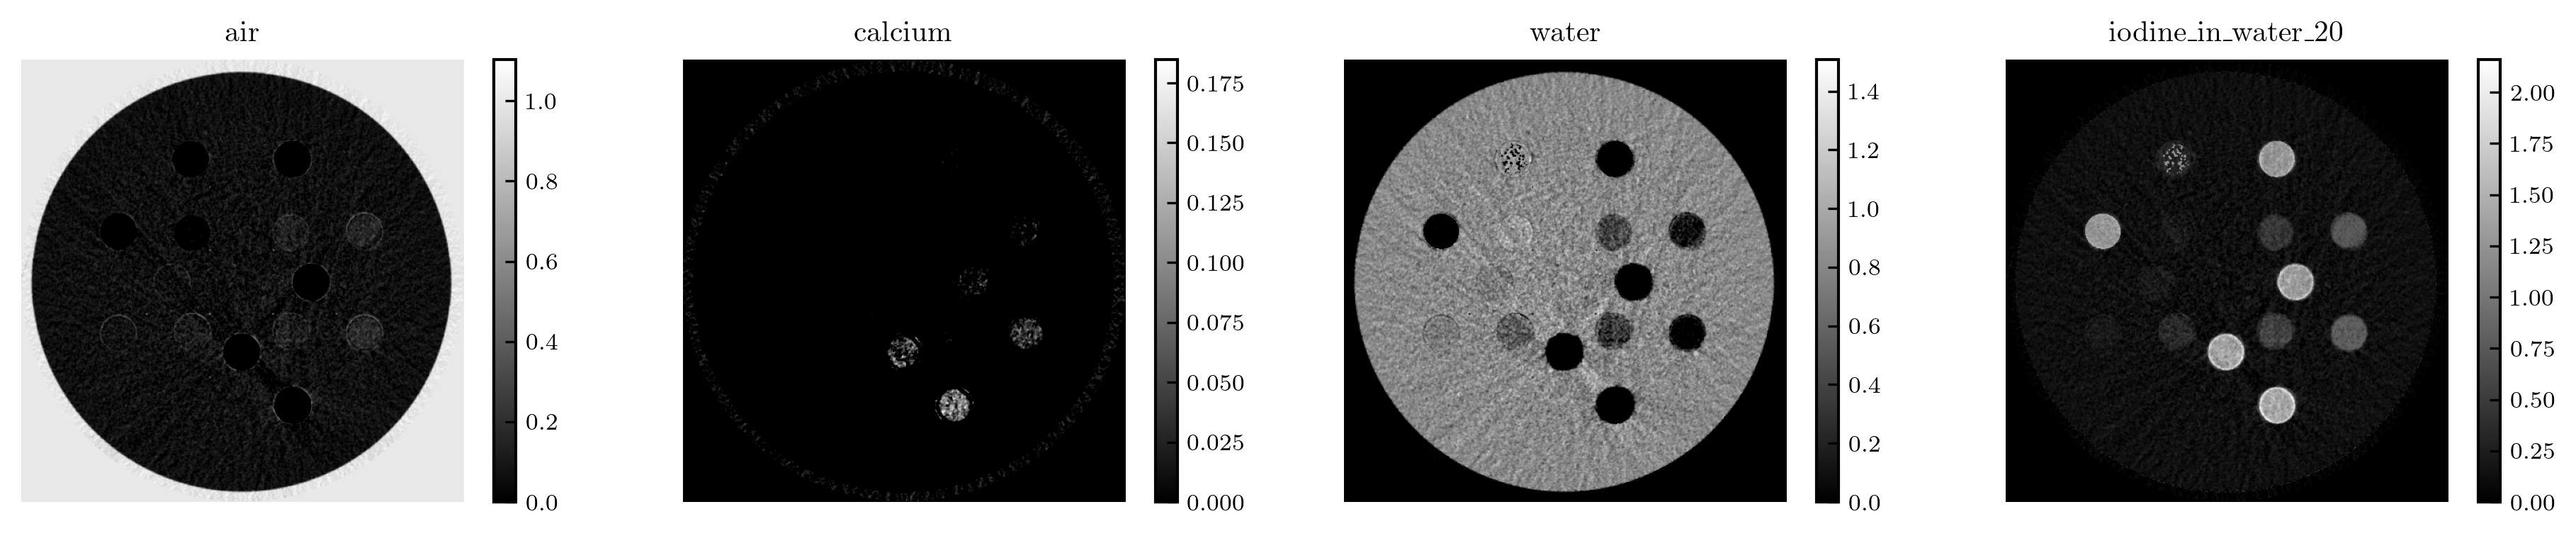

In [34]:
scale = 2.5
fig, ax = plt.subplots(1,len(M_dict),figsize=[(len(M_dict)+1)*scale, scale])
for i, name in enumerate(M_dict):
    ax[i].set_title(name)
    m = ax[i].imshow(M_dict[name], cmap='gray', vmin=0)#, vmax=1)
    fig.colorbar(m, ax=ax[i])
    ax[i].grid(False)
    ax[i].axis('off')
fig.tight_layout()
plt.show()

# Putting everything together

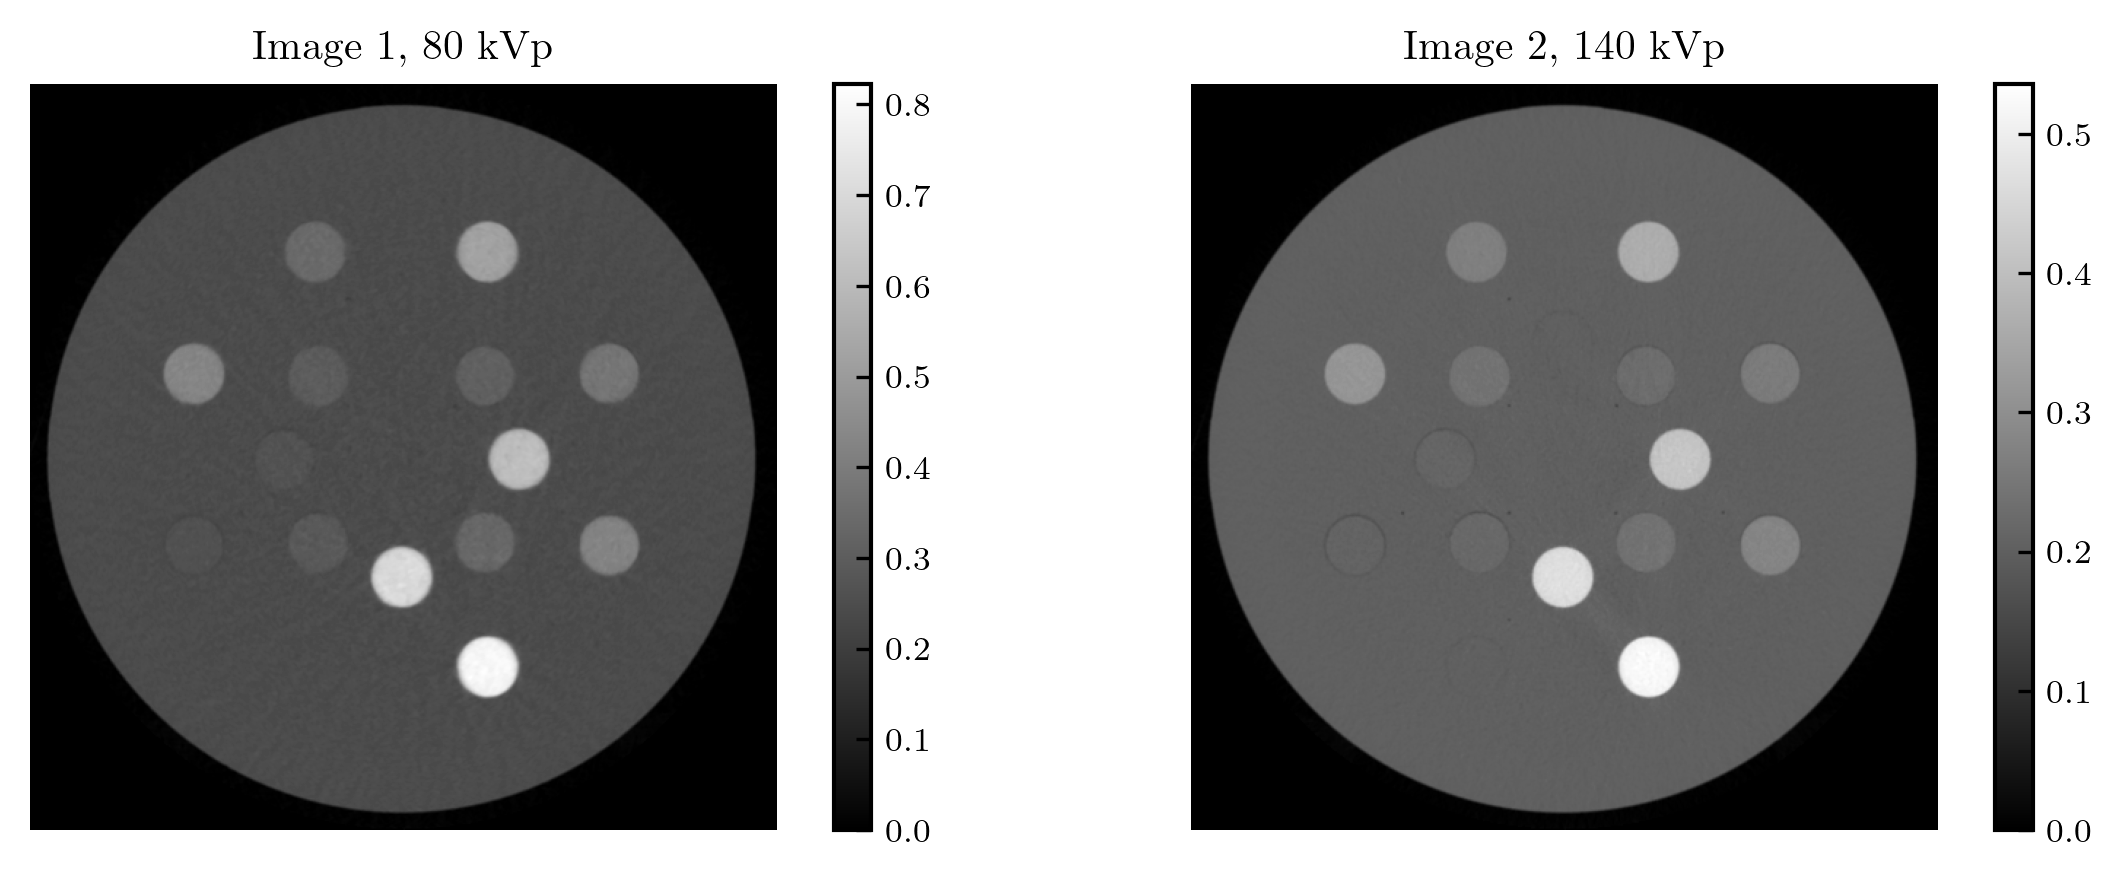

priority list of material triplets:
1 ['calcium', 'iodine_in_water_20', 'air']
2 ['iodine_in_water_20', 'water', 'air']



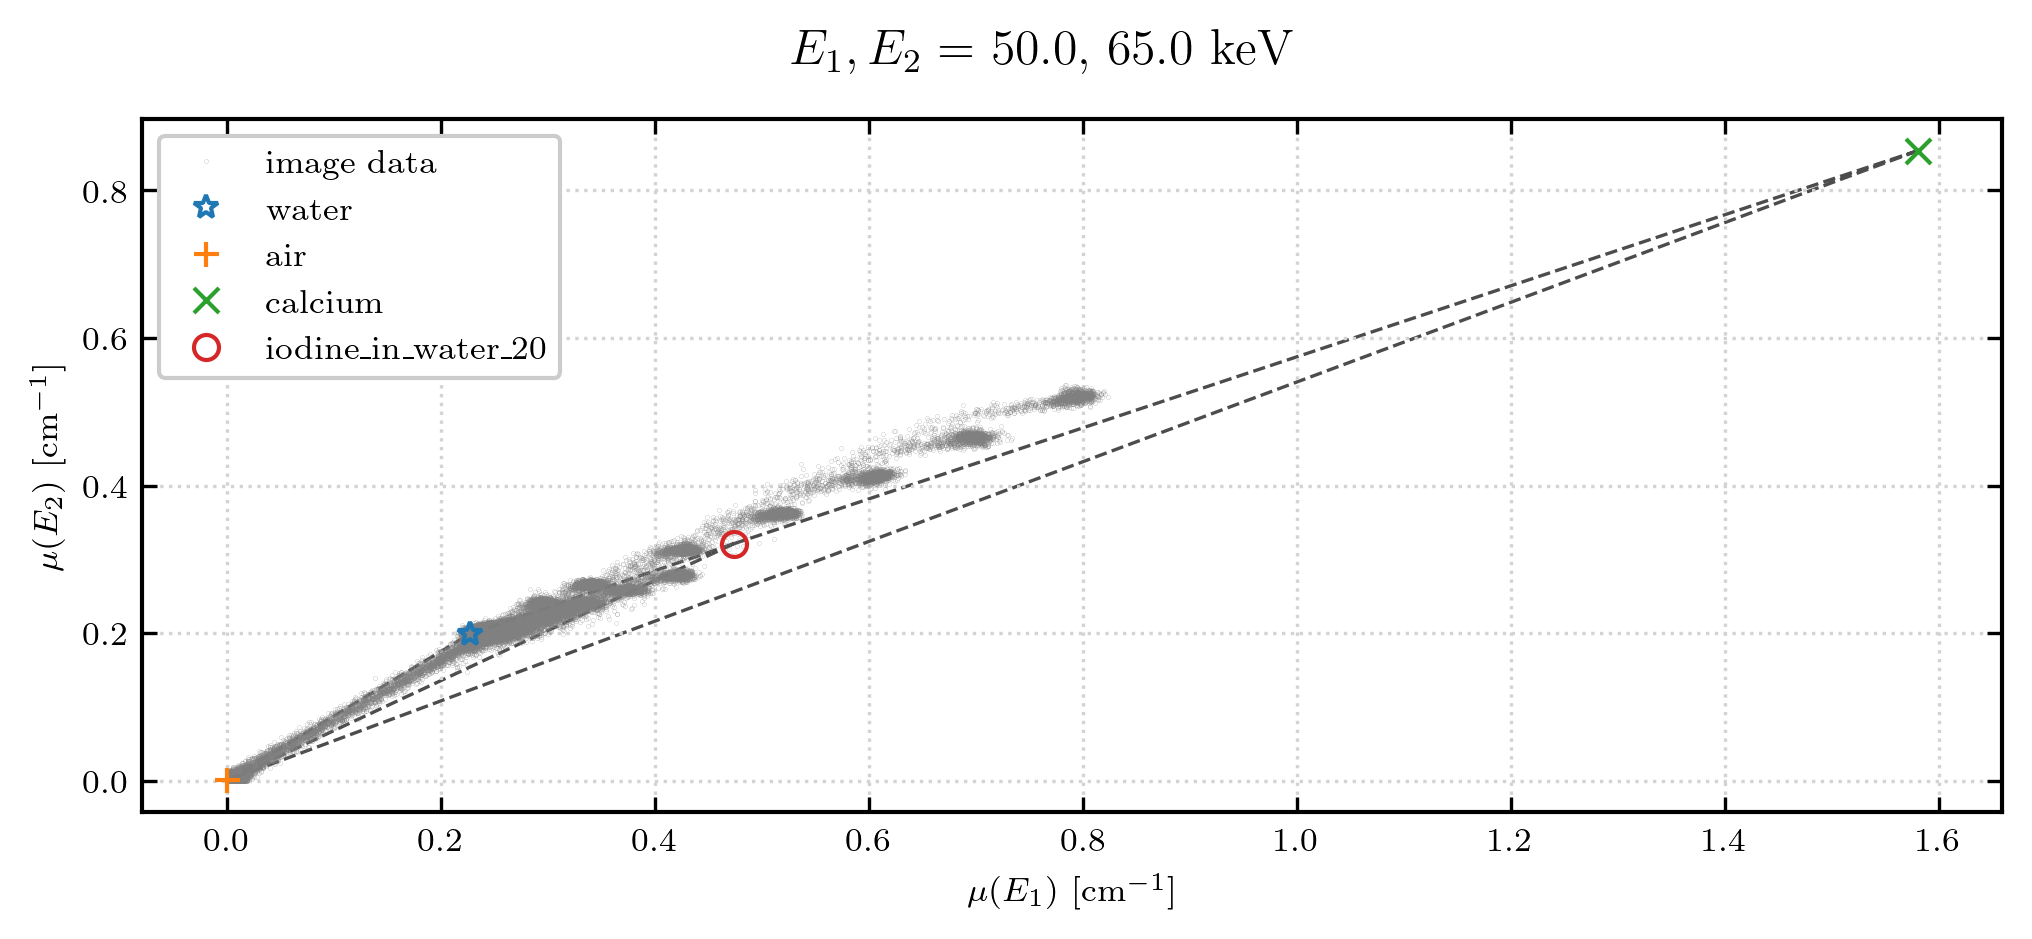

1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


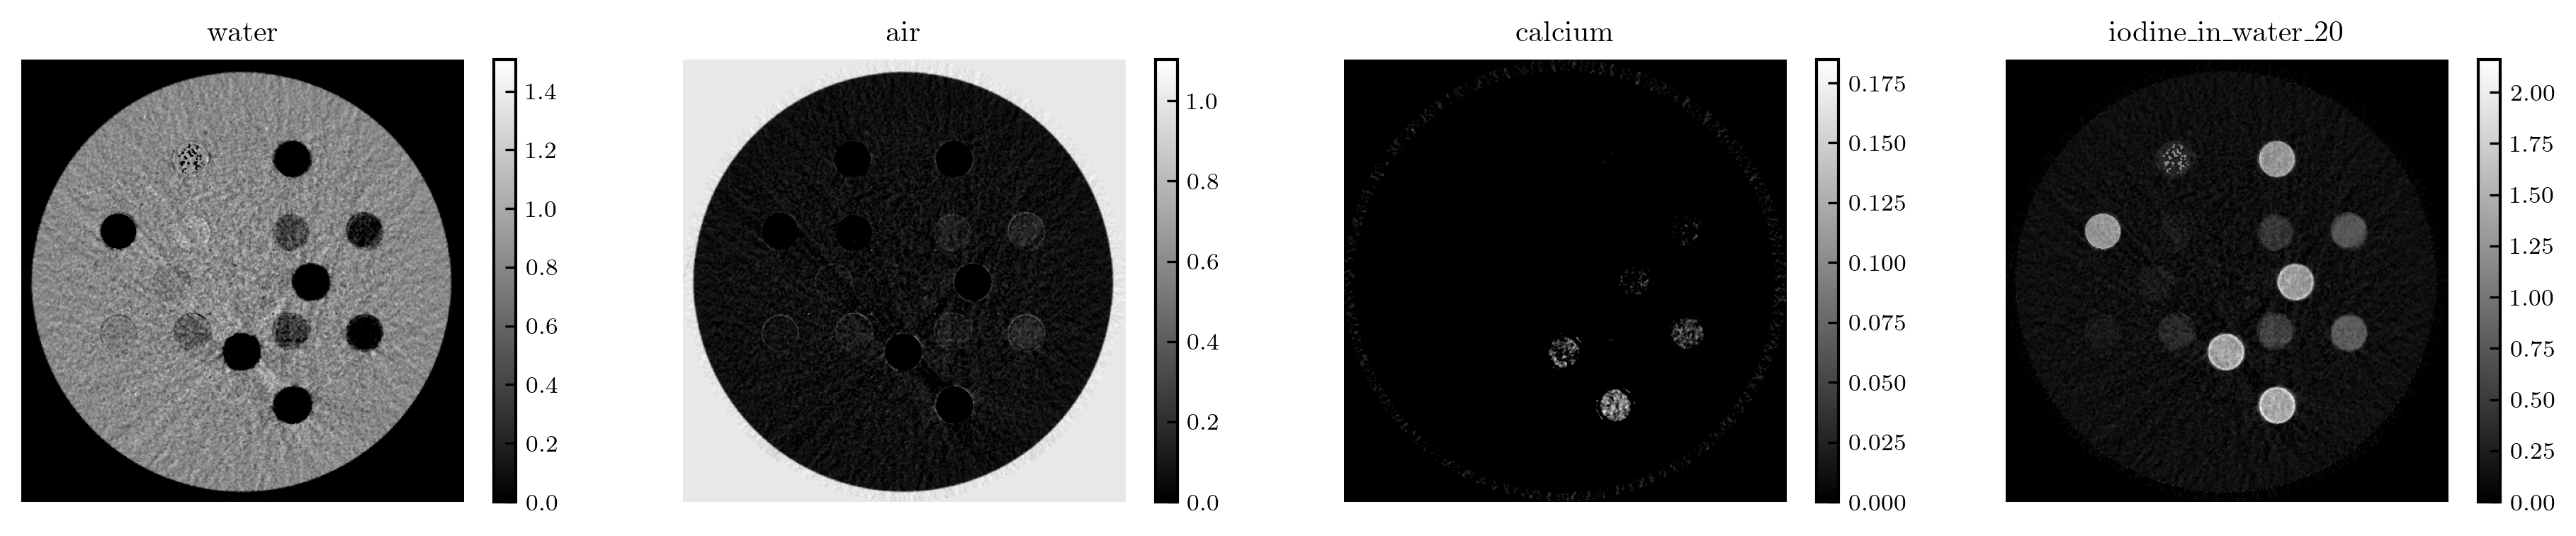

In [48]:
def mmd(material_dict, material_names, M_E1, M_E2, show_images=True, show_triples=True, show_basis_images=True):

    ### PART 1
    # create a list of Materials
    mats = []
    for m in material_names:
        mats.append(material_dict[m])
        
    # show the images
    if show_images:
        fig, ax = plt.subplots(1,2, figsize=[8,3])
        ax[0].set_title(f'Image 1, 80 kVp')
        ax[0].axis('off')
        m = ax[0].imshow(M_E1, cmap='gray')
        fig.colorbar(m, ax=ax[0])
        ax[1].set_title(f'Image 2, 140 kVp')
        ax[1].axis('off')
        m = ax[1].imshow(M_E2, cmap='gray')
        fig.colorbar(m, ax=ax[1])
        fig.tight_layout()
        plt.show()

    #### PART 2
    # initialize attenuation coeff vectors 
    # create full tesselation of triplets
    points = []
    for mat in mats:
        mat.init_atten_coeffs(E)
        points.append(mat.mu)
    points = np.array(points)
    tri = Delaunay(points)

    # print priority list of triplets
    print('priority list of material triplets:')
    for i, tri_inds in enumerate(tri.simplices):
        triplet = np.take(mats, tri_inds)
        triplet_names = [m.name for m in triplet]
        print(i+1, triplet_names)
    print()

    # show the triples
    if show_triples:
        fig, ax = plt.subplots(1,1, figsize=[8,3])
        fig.suptitle(f'$E_1, E_2 =$ {E1}, {E2} keV')
        plt.plot(M_E1.ravel(), M_E2.ravel(), marker='.', color='gray', ls='', markersize=.1, label='image data')
        ax.triplot(points[:,0], points[:,1], tri.simplices, 'k--', lw=.8, alpha=0.7)
        for mat in mats:
            ax.plot(mat.mu[0], mat.mu[1], marker=next(marker), ls='', markerfacecolor='None', label=mat.name)
        ax.set_xlabel('$\mu(E_1)$ [cm$^{-1}$]')
        ax.set_ylabel('$\mu(E_2)$ [cm$^{-1}$]')
        ax.legend()
        plt.show()

        
    #### PART 3
    # compute basis material images
    M_dict = {}
    for m in mats:
        M_dict[m.name] = np.zeros([512,512], dtype=np.float32)

    # compute images
    for i in range(512):
        if i in [x for x in range(0, 512,512//10)]:
            print(f'{int(100*i/512)+1}%')
        for j in range(512):
            mu_px = np.array([M_E1[i,j], M_E2[i,j]])
            triplet_names, alphas = get_alphas(mu_px, mats, tri)
            for k, name in enumerate(triplet_names):
                M_dict[name][i,j] = alphas[k]
                
    # show images
    if show_basis_images:
        scale = 2.5
        fig, ax = plt.subplots(1,len(M_dict),figsize=[(len(M_dict)+1)*scale, scale])
        for i, name in enumerate(M_dict):
            ax[i].set_title(name)
            m = ax[i].imshow(M_dict[name], cmap='gray', vmin=0)#, vmax=1)
            fig.colorbar(m, ax=ax[i])
            ax[i].grid(False)
            ax[i].axis('off')
        fig.tight_layout()
        plt.show()

matnames = ['water',  'air', 'calcium', 'iodine_in_water_20']
mmd(mdict, matnames, M_E1, M_E2)


priority list of material triplets:
1 ['iodine', 'calcium', 'air']
2 ['calcium', 'water', 'air']
3 ['water', 'calcium', 'iodine']



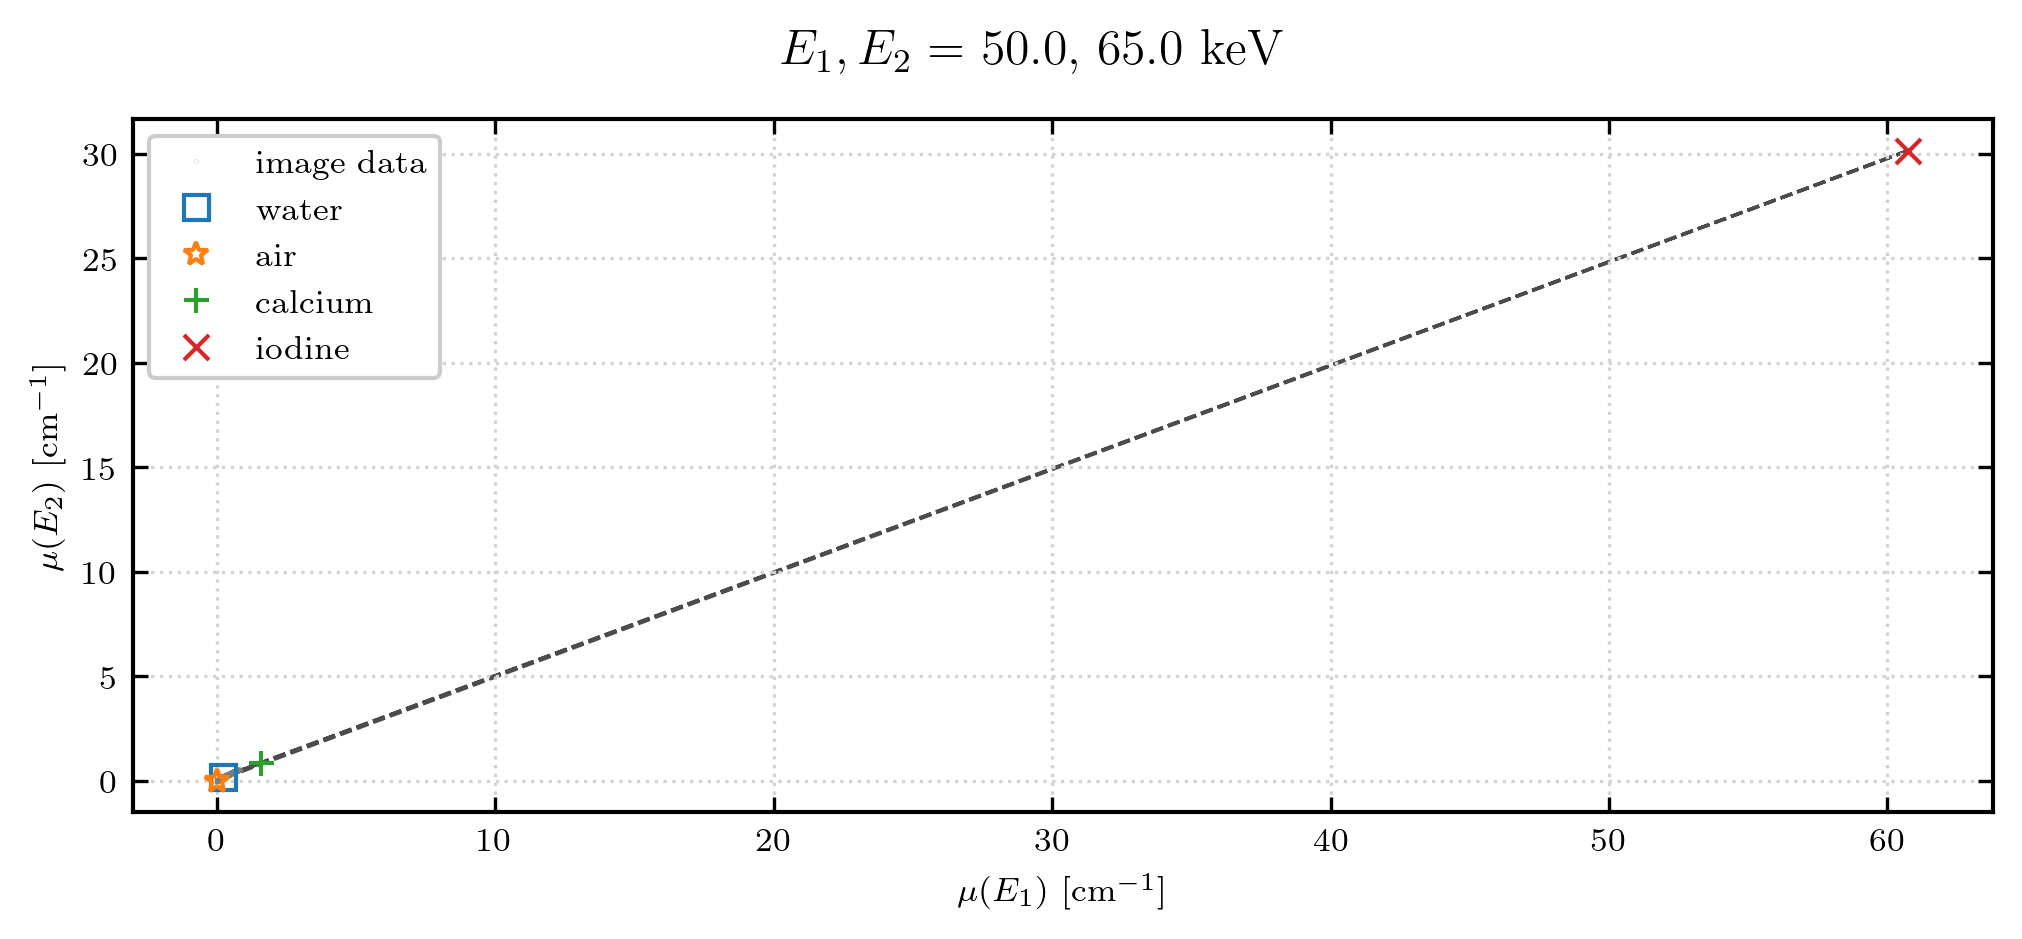

1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


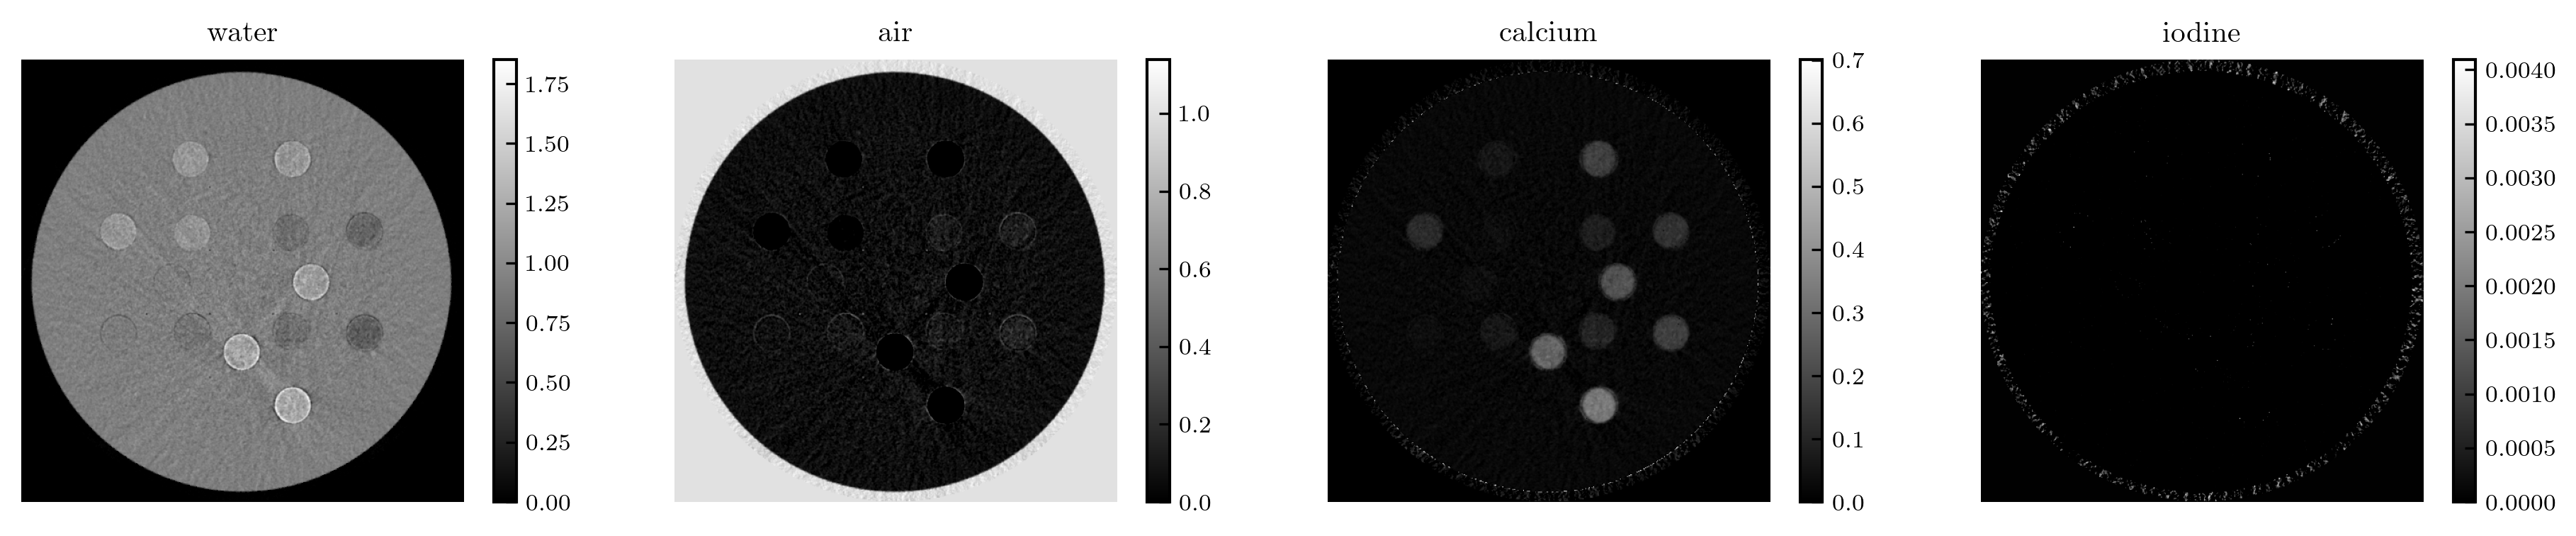

In [49]:
matnames = ['water',  'air', 'calcium', 'iodine']
mmd(mdict, matnames, M_E1, M_E2, show_images=False)